<a href="https://colab.research.google.com/github/annefrancine/DataScience_Estiam/blob/main/reconnaissance_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importez les modules et dépendances nécessaires.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importer l'ensemble de données des commandes vocales

Vous allez rédiger un script pour télécharger une partie de l' ensemble de données Speech Commands . L'ensemble de données original se compose de plus de 105 000 fichiers audio WAV de personnes disant trente mots différents. Ces données ont été collectées par Google et publiées sous licence CC BY.

Vous utiliserez une partie de l'ensemble de données pour gagner du temps lors du chargement des données. Extrayez le mini_speech_commands.zip et chargez-le à l'aide de l'API tf.data

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 2s 0us/step


In [3]:
# Vérifiez les statistiques de base sur l'ensemble de données
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'left' 'go' 'no' 'down' 'up' 'stop' 'yes']


In [4]:
# Extrayez les fichiers audio dans une liste et mélangez-la
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/c120e80e_nohash_1.wav', shape=(), dtype=string)


Divisez les fichiers en ensembles d'entraînement, de validation et de test en utilisant un ratio de 80:10:10, respectivement.

In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Lecture de fichiers audio et de leurs étiquettes

Le fichier audio sera initialement lu comme un fichier binaire, que vous voudrez convertir en un tenseur numérique.

Pour charger un fichier audio, vous utiliserez tf.audio.decode_wav , qui renvoie l'audio encodé WAV en tant que Tensor et la fréquence d'échantillonnage.

Un fichier WAV contient des données de séries temporelles avec un nombre défini d'échantillons par seconde. Chaque échantillon représente l'amplitude du signal audio à ce moment précis. Dans un système 16 bits, comme les fichiers dans mini_speech_commands , les valeurs vont de -32768 à 32767. La fréquence d'échantillonnage pour cet ensemble de données est de 16kHz. Notez que tf.audio.decode_wav normalisera les valeurs dans la plage [-1.0, 1.0].

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
# L'étiquette de chaque fichier WAV est son répertoire parent.
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

Définissons une méthode qui prendra le nom de fichier du fichier WAV et produira un tuple contenant l'audio et les étiquettes pour l'entraînement supervisé.

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Vous allez maintenant appliquer process_path pour créer votre ensemble d'apprentissage afin d'extraire les paires d'étiquettes audio et vérifier les résultats. Vous construirez les ensembles de validation et de test en utilisant une procédure similaire plus tard.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

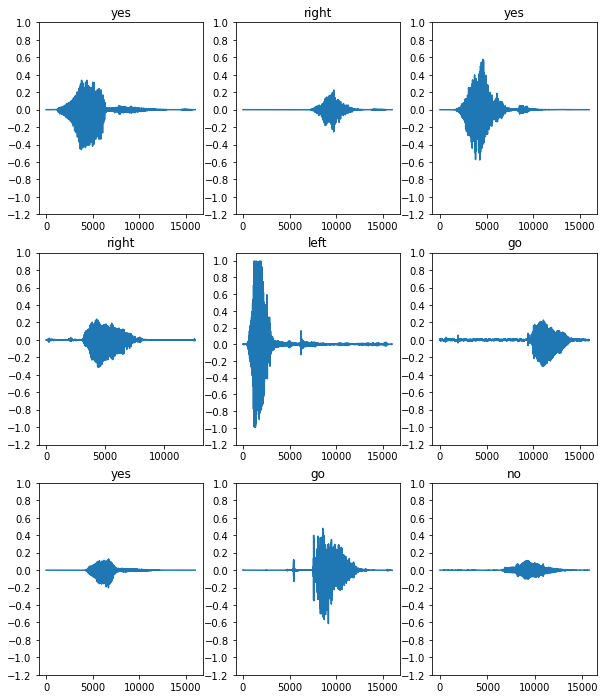

In [11]:
# Examinons quelques formes d'onde audio avec leurs étiquettes correspondantes.
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogramme
Vous allez convertir la forme d'onde en un spectrogramme, qui montre les changements de fréquence au fil du temps et peut être représenté sous la forme d'une image 2D. Cela peut être fait en appliquant la transformée de Fourier à court terme (STFT) pour convertir l'audio dans le domaine temps-fréquence.

Une transformée de Fourier ( tf.signal.fft ) convertit un signal en ses fréquences composantes, mais perd toutes les informations temporelles. Le tf.signal.stft ( tf.signal.stft ) divise le signal en fenêtres temporelles et exécute une transformée de Fourier sur chaque fenêtre, préservant certaines informations temporelles et renvoyant un tenseur 2D sur lequel vous pouvez exécuter des convolutions standard.

STFT produit un tableau de nombres complexes représentant l'amplitude et la phase. Cependant, vous n'aurez besoin que de la magnitude pour ce didacticiel, qui peut être dérivée en appliquant tf.abs sur la sortie de tf.signal.stft .

Choisissez les paramètres frame_length et frame_step sorte que l'« image » du spectrogramme généré soit presque carrée. Pour plus d'informations sur le choix des paramètres STFT, vous pouvez vous référer à cette vidéo sur le traitement du signal audio.

Vous souhaitez également que les formes d'onde aient la même longueur, de sorte que lorsque vous les convertissez en image de spectrogramme, les résultats aient des dimensions similaires. Cela peut être fait en supprimant simplement à zéro les clips audio qui sont plus courts qu'une seconde.

In [12]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

Ensuite, vous explorerez les données. Comparez la forme d'onde, le spectrogramme et l'audio réel d'un exemple de l'ensemble de données.

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


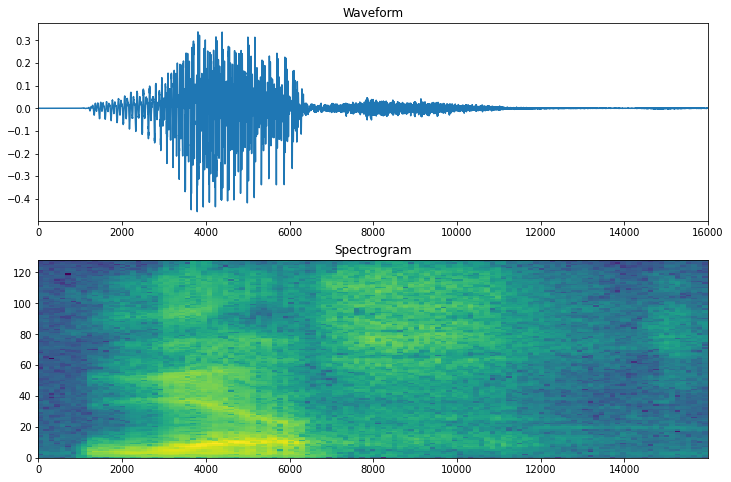

In [14]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Transformez maintenant l'ensemble de données de forme d'onde pour avoir des images de spectrogramme et leurs étiquettes correspondantes en tant qu'ID entiers.

In [15]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [16]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examinez les "images" du spectrogramme pour différents échantillons de l'ensemble de données.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


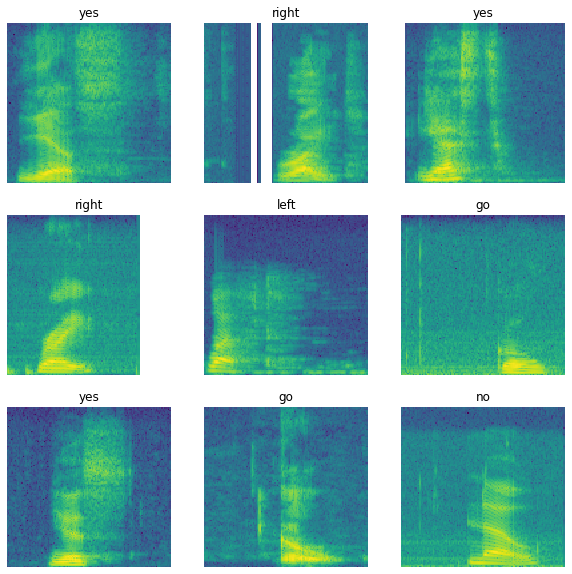

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Construire et entraîner le modèle

Vous pouvez maintenant créer et entraîner votre modèle. Mais avant cela, vous devrez répéter le prétraitement de l'ensemble d'apprentissage sur les ensembles de validation et de test.

In [18]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [19]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [20]:
# Regroupez les ensembles d'entraînement et de validation pour l'entraînement du modèle
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Ajoutez des opérations cache() et prefetch() ensemble de données pour réduire la latence de lecture lors de l'entraînement du modèle.

In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Pour le modèle, vous utiliserez un simple réseau de neurones convolutifs (CNN), puisque vous avez transformé les fichiers audio en images de spectrogramme. Le modèle comporte également les couches de prétraitement supplémentaires suivantes :

- Une couche de Resizing pour sous-échantillonner l'entrée afin de permettre au modèle de s'entraîner plus rapidement.
- Une Normalization couche de normaliser chaque pixel de l'image en fonction de son écart moyen et standard.

Pour la couche de Normalization , sa méthode d' adapt devrait d'abord être appelée sur les données d'apprentissage afin de calculer les statistiques agrégées (c'est-à-dire la moyenne et l'écart type).

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 42s 411ms/step - loss: 1.7472 - accuracy: 0.3745 - val_loss: 1.2718 - val_accuracy: 0.6000
Epoch 2/10
100/100 [==============================] - 23s 228ms/step - loss: 1.1577 - accuracy: 0.6003 - val_loss: 0.9329 - val_accuracy: 0.7025
Epoch 3/10
100/100 [==============================] - 22s 221ms/step - loss: 0.8856 - accuracy: 0.6881 - val_loss: 0.7934 - val_accuracy: 0.7563
Epoch 4/10
100/100 [==============================] - 22s 223ms/step - loss: 0.7387 - accuracy: 0.7420 - val_loss: 0.7050 - val_accuracy: 0.7713
Epoch 5/10
100/100 [==============================] - 22s 223ms/step - loss: 0.6154 - accuracy: 0.7850 - val_loss: 0.6571 - val_accuracy: 0.7925
Epoch 6/10
100/100 [==============================] - 22s 220ms/step - loss: 0.5419 - accuracy: 0.8086 - val_loss: 0.6474 - val_accuracy: 0.7837
Epoch 7/10
100/100 [==============================] - 22s 221ms/step - loss: 0.4681 - accuracy: 0.8344 - val_loss: 0.5888 - val_ac

Vérifions les courbes de perte d'entraînement et de validation pour voir comment votre modèle s'est amélioré pendant l'entraînement.

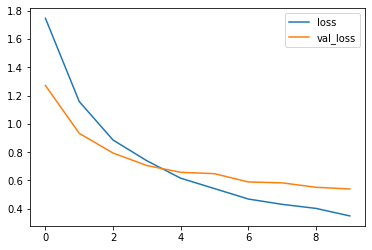

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Évaluer les performances de l'ensemble de test

Exécutons le modèle sur l'ensemble de test et vérifions les performances.

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [27]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 87%


## Afficher une matrice de confusion

Une matrice de confusion est utile pour voir à quel point le modèle s'est bien comporté sur chacune des commandes de l'ensemble de test.

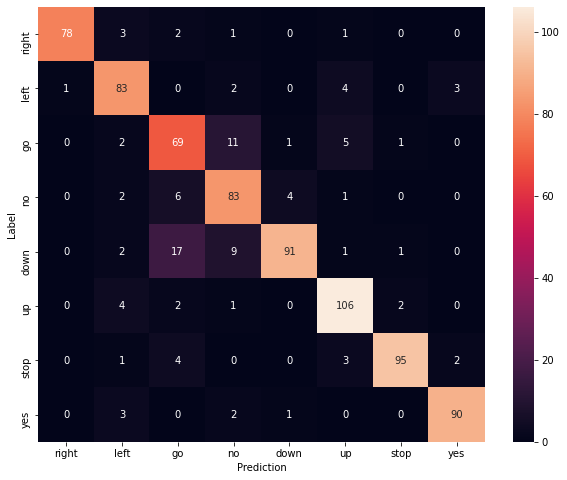

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Exécuter l'inférence sur un fichier audio

Enfin, vérifiez la sortie de prédiction du modèle à l'aide d'un fichier audio d'entrée de quelqu'un disant « non ». Quelle est la performance de votre modèle ?

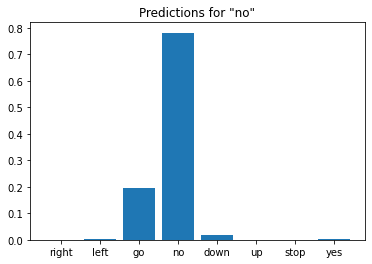

In [29]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

Vous pouvez voir que votre modèle a très clairement reconnu la commande audio comme "non".